In [1]:
import scanpy as sc
import pandas as pd
import seaborn as sns

# Salmon data (no gtf)

In [5]:
!pwd

/project/meissner_external_data/SingleCell/Tyser_human_gastrulation/script


In [6]:
adata = sc.read_csv("/project/meissner_external_data/SingleCell/Tyser_human_gastrulation/data/salmon_genes_count_matrix.csv", delimiter=',')
adata

FileNotFoundError: [Errno 2] No such file or directory: '/project/meissner_external_data/SingleCell/Tyser_human_gastrulation/data/salmon_genes_count_matrix.csv'

In [3]:
sc.pp.normalize_total(adata)

NameError: name 'adata' is not defined

In [4]:
sc.pp.log1p(adata)

In [5]:
sc.pp.highly_variable_genes(adata, n_top_genes=4000)

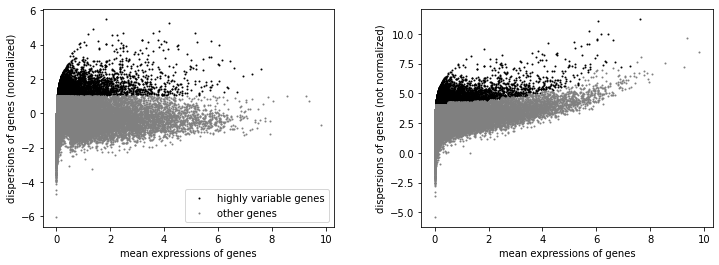

In [6]:
sc.pl.highly_variable_genes(adata)

In [7]:
#adata = adata[:, adata.var.highly_variable]

In [9]:
sc.pp.pca(adata, use_highly_variable=True)

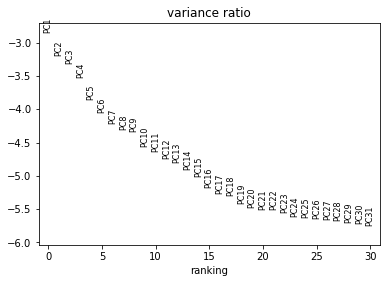

In [10]:
sc.pl.pca_variance_ratio(adata, log=True)

In [11]:
sc.pp.neighbors(adata, n_pcs=30, method='umap')

2021-12-07 11:40:58.693717: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [12]:
sc.tl.umap(adata)

In [13]:
sc.tl.leiden(adata, resolution=0.75)

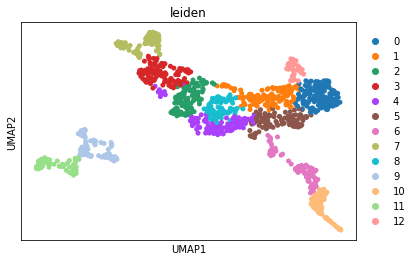

In [14]:
sc.pl.umap(adata, color='leiden')

# STAR data (bulk data)

In [95]:
#endoderm_reads_count = pd.read_csv("/project/meissner_external_data/SingleCell/Tyser_human_gastrulation/data/rnaseq_endoderm_hg19_20211208/endoderm_hg19.star.ReadsPerGene.out.tab",
#                                   sep="\t",
#                                   names=["gene_ID", "unstranded", "1st_read", "2_read"])
#endoderm_reads_count = endoderm_reads_count[["gene_ID", "unstranded"]].iloc[4::]
#endoderm_reads_count.rename(columns={"unstranded":"endoderm"}, inplace=True)
#endoderm_reads_count.set_index("gene_ID", inplace=True)

In [96]:
#not_endoderm_reads_count = pd.read_csv("/project/meissner_external_data/SingleCell/Tyser_human_gastrulation/data/rnaseq_not_endoderm_hg19_20211208/not_endoderm_hg19.star.ReadsPerGene.out.tab",
#                                   sep="\t",
#                                   names=["gene_ID", "unstranded", "1st_read", "2_read"])
#not_endoderm_reads_count = not_endoderm_reads_count[["gene_ID", "unstranded"]].iloc[4::]
#not_endoderm_reads_count.rename(columns={"unstranded":"not_endoderm"}, inplace=True)
#not_endoderm_reads_count.set_index("gene_ID", inplace=True)

In [97]:
#adata = pd.concat([endoderm_reads_count, not_endoderm_reads_count], axis=1)
#adata = adata.T
#adata.to_csv("../data/star_adata.csv", sep=',')

In [154]:
bulk_data = pd.read_csv("../data/star_bulk.csv", sep=',', index_col=0)
bulk_data = bulk_data.T

In [143]:
endo_sum = bulk_data.endoderm.sum()
not_endo_sum = bulk_data.not_endoderm.sum()
bulk_data.endoderm = bulk_data.endoderm.div(endo_sum).mul(200000)
bulk_data.not_endoderm = bulk_data.not_endoderm.div(not_endo_sum).mul(200000)

In [144]:
bulk_data = pd.melt(bulk_data,
                    value_vars=["endoderm", "not_endoderm"],
                    var_name="sample",
                    value_name="normalized_count",
                    ignore_index=False)

In [145]:
gene_names = {"ENSG00000000000.0":"lincSOX17"}
bulk_data.rename(index=gene_names, inplace=True)

In [146]:
bulk_data.reset_index(inplace=True)
bulk_data.rename(columns={"index":"gene"}, inplace=True)

<AxesSubplot:xlabel='gene', ylabel='normalized_count'>

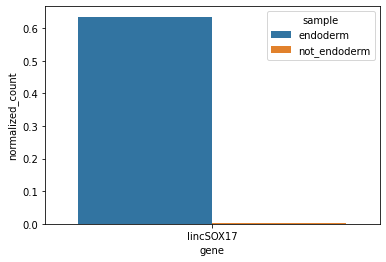

In [150]:
bulk_barplot = bulk_data[(bulk_data["gene"] == "lincSOX17")]
sns.barplot(data=bulk_barplot, x="gene", y="normalized_count", hue="sample")

# Salmon data (gtf)

In [25]:
adata = sc.read_csv("../data/salmon_gtf_genes_count_matrix.csv", delimiter=',')

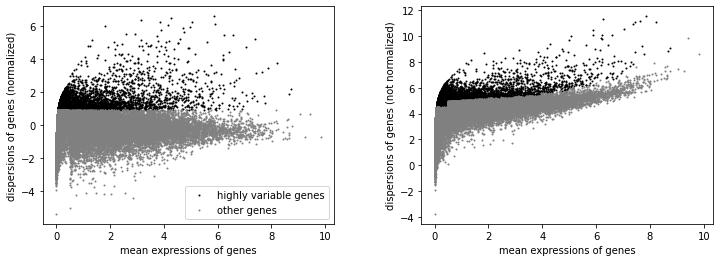

In [26]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=4000)
sc.pl.highly_variable_genes(adata)

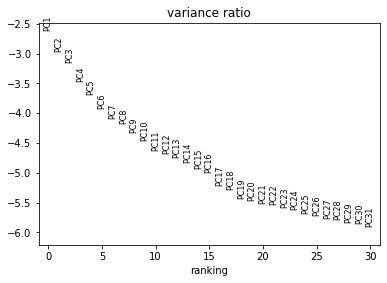

In [27]:
sc.pp.pca(adata, use_highly_variable=True)
sc.pl.pca_variance_ratio(adata, log=True)

In [28]:
sc.pp.neighbors(adata, n_pcs=30, method='umap')
sc.tl.umap(adata)

## Add cluster names from published data

In [29]:
info_df = pd.read_csv("../data/E-MTAB-9388.sdrf.txt", sep="\t")
clusters_df = info_df[["Characteristics[inferred cell type - authors labels]",
                       "Comment[ENA_RUN]"]]

clusters_df.rename(columns={"Characteristics[inferred cell type - authors labels]":"Cell-type",
                            "Comment[ENA_RUN]":"sample"}, inplace=True)

/pkg/python-3.9.7-0/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [30]:
clusters_df.drop_duplicates(subset="sample", inplace=True)
clusters_df.set_index("sample", inplace=True)

/pkg/python-3.9.7-0/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [31]:
adata.obs = pd.merge(adata.obs, clusters_df, how='inner', left_index=True, right_index=True)

In [32]:
cell_pop = {"advanced mesoderm":"Advanced mesoderm", "axial mesoderm":"Axial mesoderm",
            "ectodermal cell":"Ectoderm", "emergent mesoderm":"Emergent mesoderm",
            "endodermal cell":"Endoderm", "epiblast cell":"Epiblast", "erythrocyte":"Erythroblasts",
            "hemogenic endothelial progenitor":"Hemato-endothelial progenitors",
            "nascent mesoderm":"Nascent mesoderm", "primitive streak":"Primitive streak",
            "yolk sac mesoderm":"Extraembryonic mesoderm"}

adata.obs.replace(cell_pop, inplace=True)

/home/tornisie/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Cell-type' as categorical


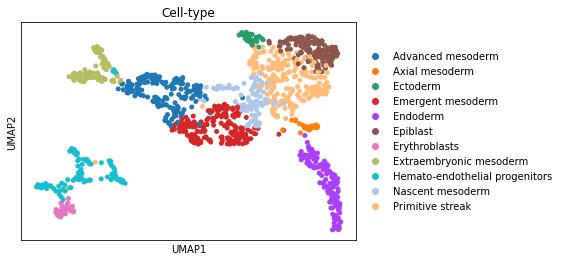

In [33]:
sc.pl.umap(adata, color="Cell-type", save="cell_type")

In [18]:
gene_names = {"ENST00000000001.1":"lincSOX17", "ENST00000000002.1":"spliced_lincSOX17", "ENSG00000164736.5":"SOX17",
              "ENSG00000125798.10":"FOXA2", "ENSG00000259974.2":"LINC00261",
              "ENSG00000133937.3":"GSC", "ENST00000000003.1":"GSC-DT",
              "ENSG00000141448.4":"GATA6","ENSG00000266010.1":"GATA6-AS1"}

In [19]:
adata.var.rename(index=gene_names, inplace=True)

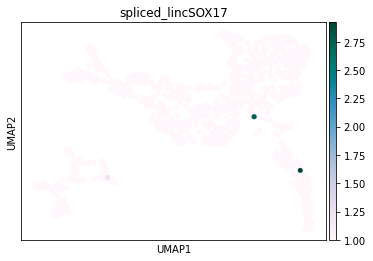

In [20]:
sc.pl.umap(adata, color="spliced_lincSOX17", color_map="PuBuGn", save="spliced_lincSOX17", vmin=1)

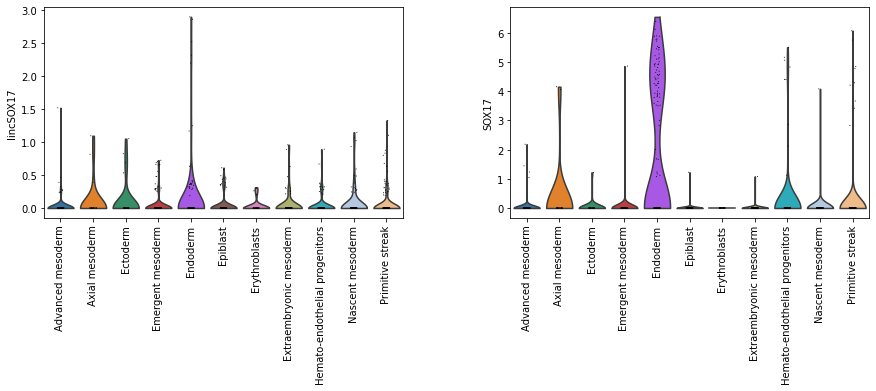

In [15]:
sc.pl.violin(adata, ["lincSOX17", "SOX17"], groupby='Cell-type', rotation=90, multi_panel=True, save="linc_SOX17.svg")

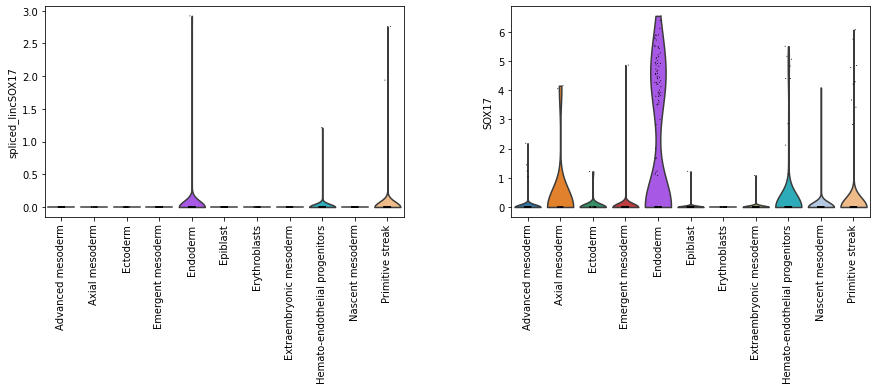

In [16]:
sc.pl.violin(adata, ["spliced_lincSOX17", "SOX17"], groupby='Cell-type', rotation=90,multi_panel=True, save="spliced_SOX17")

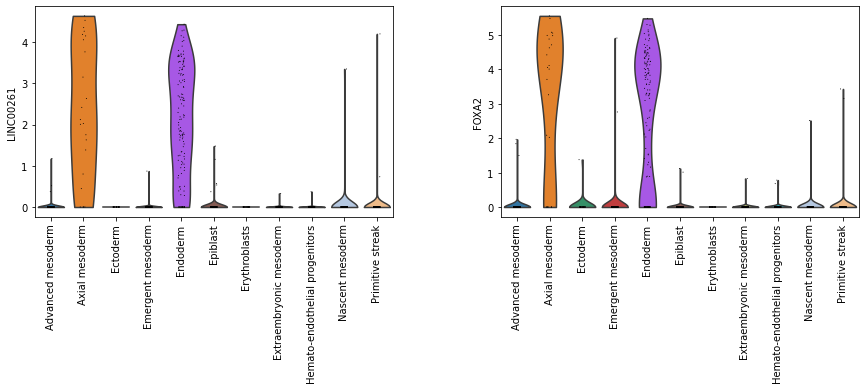

In [17]:
sc.pl.violin(adata, ["LINC00261", "FOXA2"], groupby='Cell-type', rotation=90, multi_panel=True, save="linc_FOXA2")

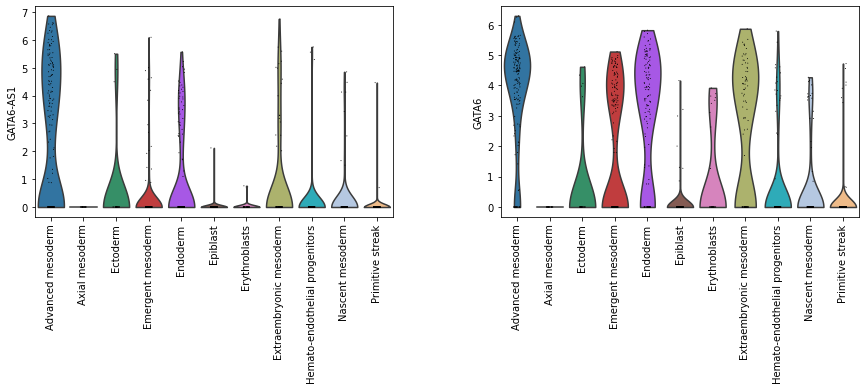

In [18]:
sc.pl.violin(adata, ["GATA6-AS1", "GATA6"], groupby='Cell-type', rotation=90, multi_panel=True, save="linc_GATA6")

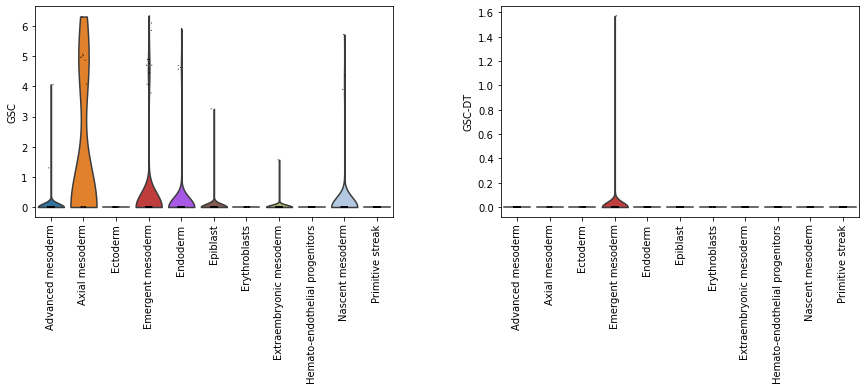

In [19]:
sc.pl.violin(adata, ["GSC", "GSC-DT"], groupby='Cell-type', rotation=90, multi_panel=True, save="linc_GSC")

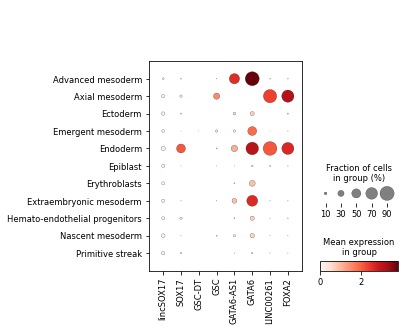

In [20]:
sc.pl.dotplot(adata, ["lincSOX17", "SOX17", "GSC-DT", "GSC", "GATA6-AS1", "GATA6", "LINC00261", "FOXA2"], groupby="Cell-type", save=True)

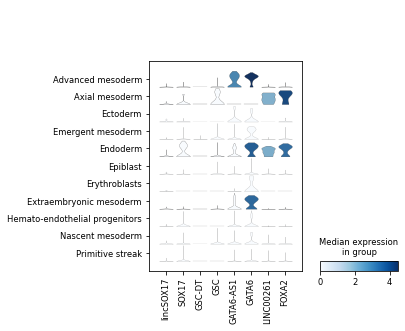

In [21]:
sc.pl.stacked_violin(adata, ["lincSOX17", "SOX17", "GSC-DT", "GSC", "GATA6-AS1", "GATA6", "LINC00261", "FOXA2"], groupby='Cell-type', rotation=90, save=True)

# Subclustering Endoderm

In [34]:
endoderm = adata[adata.obs["Cell-type"] == "Endoderm"]

In [35]:
sc.pp.highly_variable_genes(endoderm, n_top_genes=2000)
sc.pp.pca(endoderm, use_highly_variable=True)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10)

Trying to set attribute `._uns` of view, copying.


In [36]:
sc.tl.leiden(endoderm, resolution=0.75) #they use 0.75 resolution

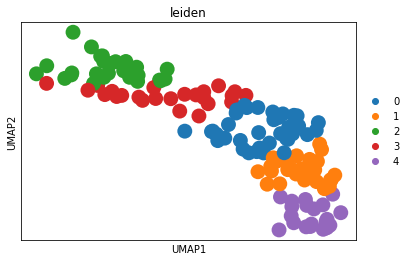

In [37]:
sc.pl.umap(endoderm, color="leiden")

In [38]:
sc.tl.diffmap(endoderm)

In [48]:
#SHISA2,OTX2,SPOCK3,AC117945.2,SIX3 (DE2)
SHISA2 = 'ENSG00000180730.4'
OTX2 =  'ENSG00000165588.12'
SPOCK3 = 'ENSG00000196104.6'
SIX3 = 'ENSG00000138083.3'

#CENPU,TK1,HMGN2,PCLAF,TMSB15A [DE1] 
CENPU = 'ENSG00000151725.7'
TK1 = 'ENSG00000167900.7'
HMGN2 = 'ENSG00000198830.6'
PCLAF = 'ENSG00000166803.6'
TMSB15A = 'ENSG00000158164.6'


#VEPH1,SERPINE2,DENND2C,S100A11,COL4A1 [Hypoblast] 
VEPH1 = 'ENSG00000197415.7'
SERPINE2 = 'ENSG00000135919.8'
DENND2C = 'ENSG00000175984.10'
S100A11 = 'ENSG00000163191.5'
COL4A1 = 'ENSG00000187498.10'


#AKR1D1,APOB,VTN,AFP,DPYS [YS]
APOB = 'ENSG00000084674.9'
AKR1D1 = 'ENSG00000122787.10'
VTN = 'ENSG00000109072.9'
AFP = 'ENSG00000081051.3'
DPYS = 'ENSG00000147647.8'

In [47]:
endoderm.var[endoderm.var.index.map(lambda x: 'ENSG00000147647' in x)]

,highly_variable,means,dispersions,dispersions_norm
ENSG00000147647.8,False,3.995264,5.144403,1.053645


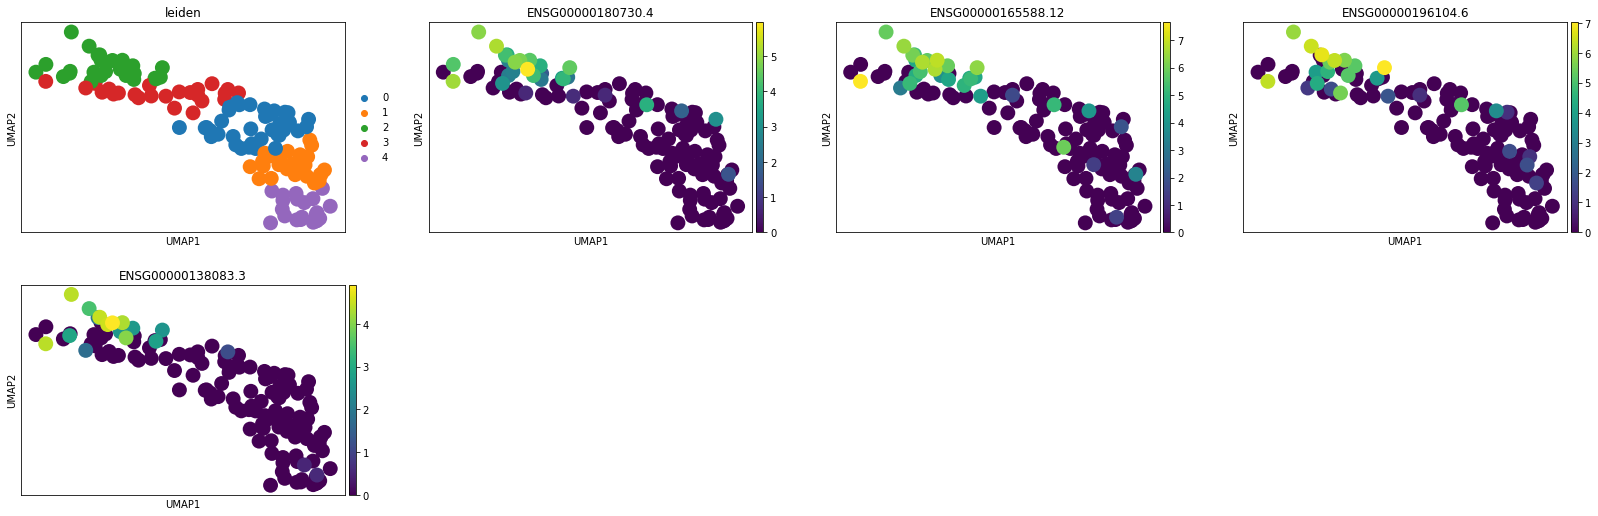

In [52]:
sc.pl.umap(endoderm, color=["leiden", SHISA2, OTX2, SPOCK3, SIX3])

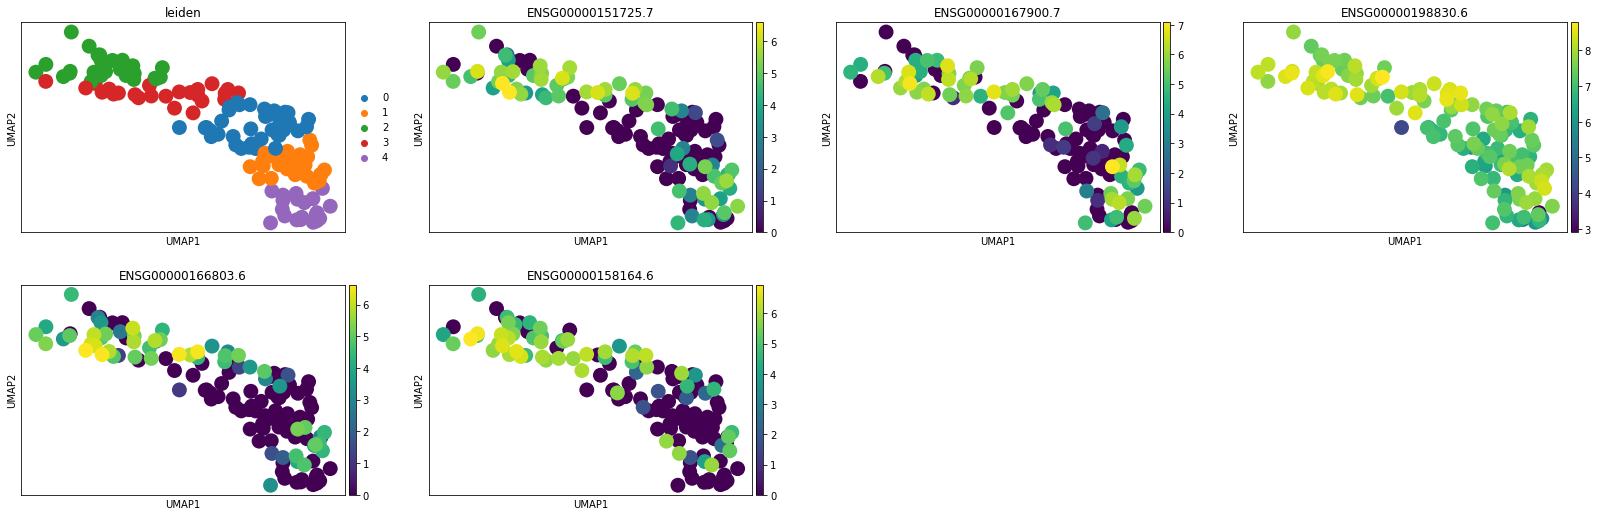

In [53]:
sc.pl.umap(endoderm, color=["leiden", CENPU, TK1, HMGN2, PCLAF, TMSB15A])

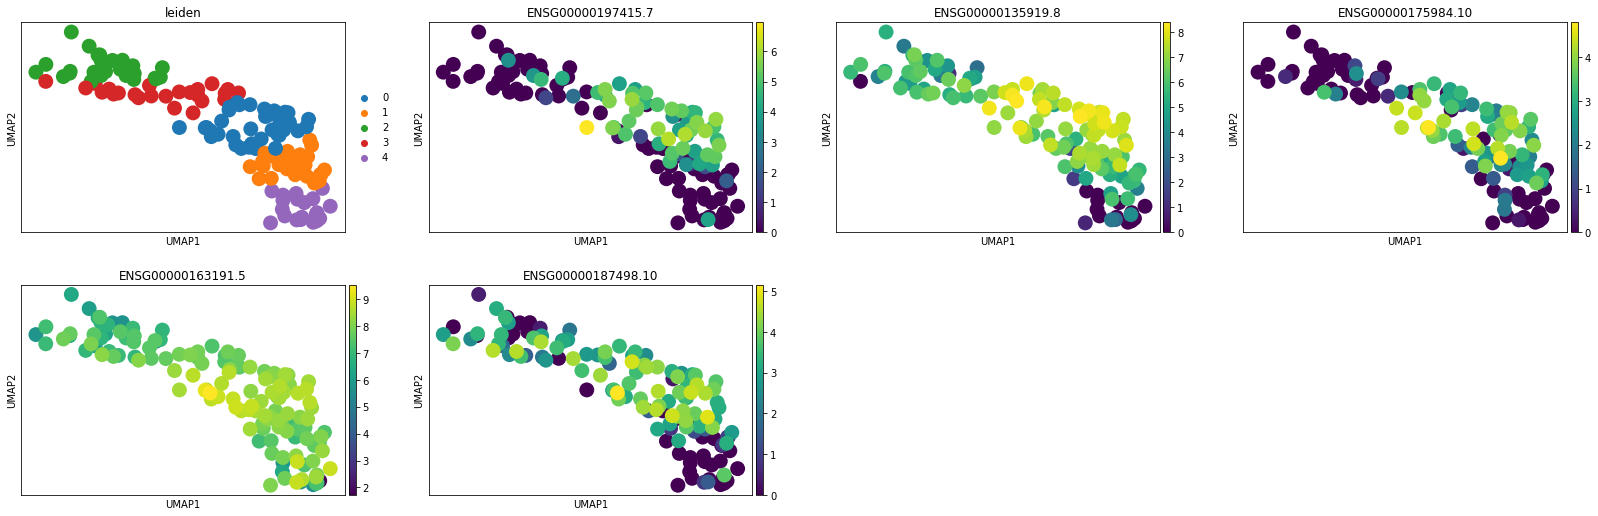

In [54]:
sc.pl.umap(endoderm, color=["leiden", VEPH1, SERPINE2, DENND2C, S100A11, COL4A1])

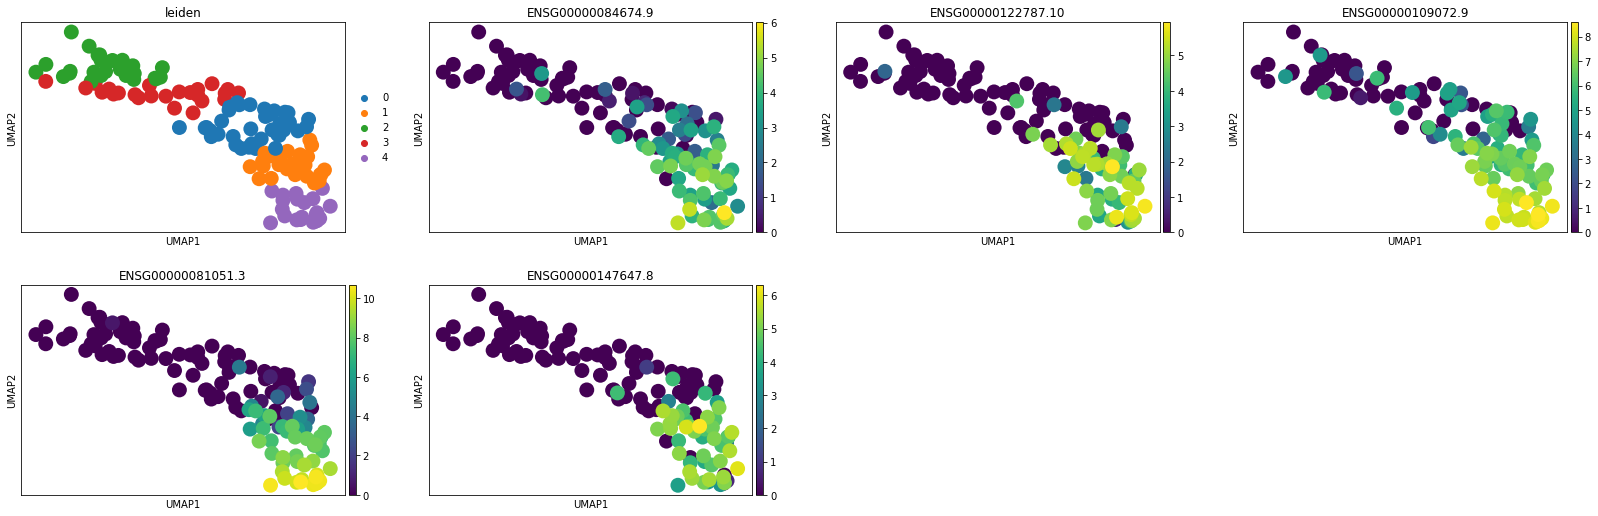

In [55]:
sc.pl.umap(endoderm, color=["leiden", APOB, AKR1D1, VTN, AFP, DPYS])

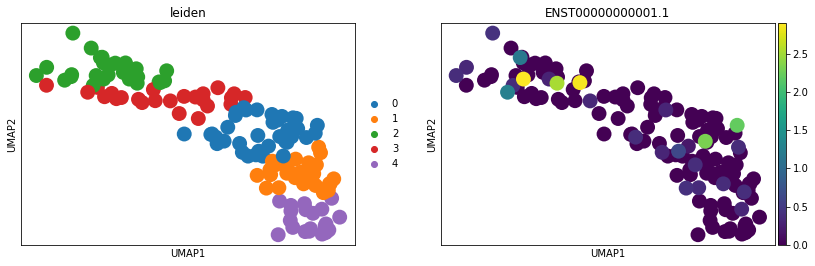

In [56]:
sc.pl.umap(endoderm, color=['leiden', 'ENST00000000001.1']) 